# 使用說明書
等等再打

# 實作程式碼

In [207]:
import xlwings as xw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft

# 需要手動輸入的資料
1. 要讀取的excel地聲電壓資料(workbook)
2. 要分析的總時間(total_time)
3. 紀錄週期(dt)
4. 震動方向X、Y、Z(direction)
5. 要分析的頻率區段(freq_lowerlimit、freq_upperlimit)

In [208]:
workbook= xw.Book("mudflow.xlsx")
sheet1= workbook.sheets[0]

total_time= 389.2
dt= 0.002
sample_rate= 1/dt
sample_num= int(sample_rate*total_time)
time= np.linspace(0,total_time, sample_num, endpoint=False)

X=[1,4]
Y=[2,5]
Z=[3,6]
direction= Z

# 電壓時域資料
* 標準地聲儀器(Data_Geo1)
* 待測地聲儀器(Data_Geo2)

In [209]:
Data_Geo1= sheet1.range((24,direction[0]),(24+sample_num-1,direction[0])).options(np.array).value
Data_Geo2= sheet1.range((24,direction[1]),(24+sample_num-1,direction[1])).options(np.array).value

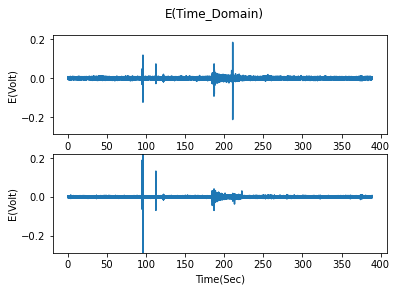

In [211]:
plt.figure(1)
plt.suptitle("E(Time_Domain)")
down= min(min(Data_Geo1),min(Data_Geo2))
up= max(max(Data_Geo1),max(Data_Geo2))

plt.subplot(2,1,1)
plt.xlabel("Time(Sec)")
plt.ylabel("E(Volt)")
plt.ylim(down,up)
plt.plot(time,Data_Geo1)
plt.subplot(2,1,2)
plt.xlabel("Time(Sec)")
plt.ylabel("E(Volt)")
plt.ylim(down,up)
plt.plot(time,Data_Geo2)

# 傅立葉轉換兩筆電壓時域資料$ \longrightarrow $頻域資料
* 標準地聲儀器(amp_E_Geo1)
* 待測地聲儀器(amp_E_Geo2)
* 有紀錄的各個頻率(fd)
* 有紀錄的各個角頻率(wd)

In [212]:
Data_Geo1_fft= fft(Data_Geo1)
Data_Geo2_fft= fft(Data_Geo2)
fd = np.linspace(0, int(sample_rate), sample_num, endpoint=False)

amp_E_Geo1= np.abs(2/sample_num *Data_Geo1_fft[0:int(sample_num/2)])
amp_E_Geo2= np.abs(2/sample_num *Data_Geo2_fft[0:int(sample_num/2)])
fd=fd[0:int(sample_num/2)]
wd=fd*2*np.pi

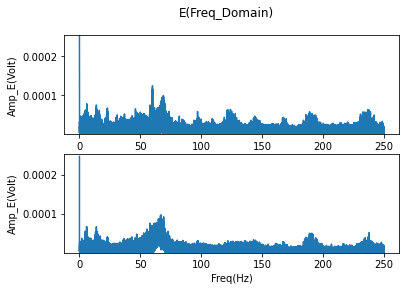

In [214]:
plt.figure(2)
plt.suptitle("E(Freq_Domain)")
down= min(min(amp_E_Geo1),min(amp_E_Geo2))
up= max(max(amp_E_Geo1),max(amp_E_Geo2))

plt.subplot(2,1,1)
plt.xlabel("Freq(Hz)")
plt.ylabel("Amp_E(Volt)")
plt.ylim(down,up)
plt.plot(fd, amp_E_Geo1)
plt.subplot(2,1,2)
plt.xlabel("Freq(Hz)")
plt.ylabel("Amp_E(Volt)")
plt.ylim(down,up)
plt.plot(fd, amp_E_Geo2)

# 需要手動輸入標準地聲儀器參數
1. 電壓敏感係數(G0)
2. 自然角頻率(a0)
3. 總電阻(Rt)
4. 磁鐵質量(m)
5. 開路阻尼(h00)

# 頻率響應函數
* 標準地聲儀器(amp_T_Geo1)

In [215]:
#地聲檢知器:GS20-DX
f0= 10 #自然頻率(Hz or 1/s)
a0= f0*2*np.pi #自然角頻率(rad/s)
m= 11 #(g)
G0= 27.6 #(V/m/s)
Rc= 395 #(Ohm)
Rs= -9999
h00= 0.3 #開路阻尼(%)

#類比訊號轉換器:PCI-1713U
Res = 12 # (bits)
MSR = 100*1000 # (S/s) = 100 (kS/s) max.
Zamp = 10**9 # 1 GΩ

#運算其他參數
if Rs == -9999:
    Rload = Zamp
else:
    Rload = (Rs*Zamp) / (Rs+Zamp) # parallel sum of Rs and Zamp

Rt = Rc + Rload #總電阻(Ohm)
bc = (G0**2)/(2*a0*m*Rt) 
bt = h00+ bc # total damping

#地聲儀器響應標準規範寫法
p1= (-a0*bt) + 1j*(a0*np.sqrt(1-bt**2))
p2= (-a0*bt) - 1j*(a0*np.sqrt(1-bt**2))
z1= 0.0 + 0j
z2= 0.0 - 0j
A0= 1
k1= -G0
k2= 1
const= A0*k1*k2

Amp= np.abs( const* (1j*wd-z1)*(1j*wd-z2)/(1j*wd-p1)/(1j*wd-p2) )
Pha= np.angle( const* ((1j*wd-z1)*(1j*wd-z2))/((1j*wd-p1)*(1j*wd-p2)), deg=True)

amp_T_Geo1= Amp

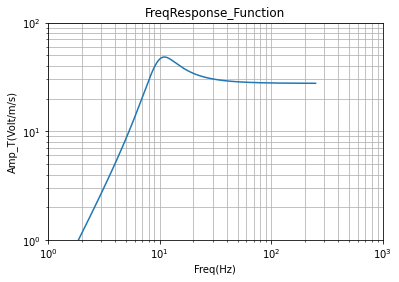

In [216]:
plt.figure(3)
plt.title("FreqResponse_Function")
plt.loglog(basex=10,basey=10)
plt.xlim(1,1000)
plt.ylim(1,100)
plt.xlabel("Freq(Hz)")
plt.ylabel("Amp_T(Volt/m/s)")
plt.plot(fd,Amp)
plt.grid(which='major', axis='both', linewidth=0.75)
plt.grid(which='minor', axis='both', linewidth=0.75)

# 地表震動速度頻域資料
* 標準地聲儀器(amp_V_Geo1)

In [217]:
#df 是上面所有地聲資料(總整理)
df= pd.DataFrame(fd,columns=['freq(1/sec)'])
df['anglefreq(rad/sec)']= wd
df['amp_E_Geo1(volt)']= amp_E_Geo1
df['amp_T_Geo1(volt/m/s)']= amp_T_Geo1
df['amp_V_Geo1(m/s)']= df['amp_E_Geo1(volt)']/df['amp_T_Geo1(volt/m/s)']
df['amp_V_Geo1(m/s)'].iloc[0]=0

df['amp_E_Geo2(volt)']= amp_E_Geo2

amp_V_Geo1= df['amp_V_Geo1(m/s)'].values

df

,freq(1/sec),anglefreq(rad/sec),amp_E_Geo1(volt),amp_T_Geo1(volt/m/s),amp_V_Geo1(m/s),amp_E_Geo2(volt)
0,0.000000,0.000000,0.000253,0.000000,0.000000e+00,0.000247
1,0.002569,0.016144,0.000018,0.000002,9.630647e+00,0.000011
2,0.005139,0.032288,0.000020,0.000007,2.789283e+00,0.000018
3,0.007708,0.048432,0.000007,0.000016,4.472478e-01,0.000015
4,0.010277,0.064575,0.000009,0.000029,2.982243e-01,0.000004
...,...,...,...,...,...,...
97295,249.987153,1570.715608,0.000005,27.636251,1.888950e-07,0.000002
97296,249.989723,1570.731751,0.000009,27.636250,3.256600e-07,0.000010
97297,249.992292,1570.747895,0.000009,27.636249,3.363971e-07,0.000004
97298,249.994861,1570.764039,0.000007,27.636249,2.519764e-07,0.000006


(0.0, 0.00015)

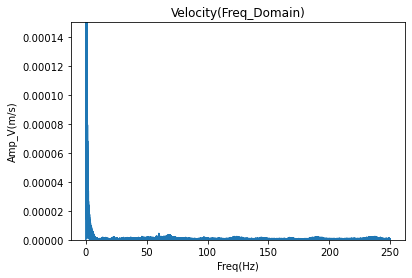

In [218]:
plt.figure(4)
plt.title("Velocity(Freq_Domain)")
down= min(amp_V_Geo1)
up= max(amp_V_Geo1)

plt.plot(fd,amp_V_Geo1)
plt.xlabel("Freq(Hz)")
plt.ylabel("Amp_V(m/s)")
plt.ylim(down,0.00015)

# 擷取要分析的頻率段資料，傳到excel

* 2~5Hz: log圖上等距離取5個點
* 5~40Hz: peak段每0.5Hz取1點
* 40~100Hz: log圖上等距離取5個點

In [275]:
import math
p1= 2
p2= 5
p3= 40
p4= 100


##df_select1、2、3分成三段
df_select1= df[(df['freq(1/sec)'] >= p1) & (df['freq(1/sec)'] <= p2)]
df_select2= df[(df['freq(1/sec)'] > p2) & (df['freq(1/sec)'] < p3)]
df_select3= df[(df['freq(1/sec)'] >= p3) & (df['freq(1/sec)'] <= p4)]

df_select1.reset_index(inplace=True, drop=True)
df_select2.reset_index(inplace=True, drop=True)
df_select3.reset_index(inplace=True, drop=True)


#第一段
fd1=np.linspace(math.log(p1,10),math.log((p2),10),5)
fd1= (10**fd1)
choose1=np.zeros([5,1])

for i in range(len(fd1)):
    choose1[i]= int((len(df_select1)-1)*(fd1[i]-p1)/(p2-p1)) 
    
df_select1= df_select1.iloc[[0,200,452,768,1166],:]


#第二段
df_select2['remain']= round(df_select2['freq(1/sec)'])
df_select2['feature']= df_select2['freq(1/sec)']-df_select2['remain']
df_select2= df_select2[(df_select2['feature'] > 0.494861252)]
df_select2= df_select2.drop(columns=['remain','feature'])


#第三段
fd3=np.linspace(math.log(p3,10),math.log((p4),10),5)
fd3= (10**fd3)
choose3=np.zeros([5,1])

for i in range(len(fd3)):
    choose3[i]= int((len(df_select3)-1)*(fd3[i]-p3)/(p4-p3))
    
df_select3= df_select3.iloc[[0,4007,9047,15383,23352],:]
    
df_select= df_select1.append(df_select2)
df_select= df_select.append(df_select3)

len(df_select2)

    



<ipython-input-275-b69c1b9725b7>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select2['remain']= round(df_select2['freq(1/sec)'])
<ipython-input-275-b69c1b9725b7>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select2['feature']= df_select2['freq(1/sec)']-df_select2['remain']


73

In [277]:
df_select.to_excel("Result.xlsx",sheet_name='data')

# 最陡梯度法(SteepestDescentMethod)猜待測地聲儀器參數組
## 待測儀器參數
1. G: 電壓敏感係數
2. a: 自然角頻率
3. b: $2 \times R \times M$ =$2 \times 總電阻 \times 磁鐵質量$
4. h0: 開路阻尼

## SDM設定
1. 起始位置(start)
2. 學習率(learning_rate)
3. 猜測次數(guess_time)
4. 結束條件(end_condition)--當走的步伐很小很小，猜測提早結束
5. 紀錄每步的紀錄(recordingBox)

In [278]:
wd= df_select["anglefreq(rad/sec)"].values
amp_E_Geo1= df_select["amp_E_Geo1(volt)"].values
amp_T_Geo1= df_select["amp_T_Geo1(volt/m/s)"].values
amp_V_Geo1= df_select["amp_V_Geo1(m/s)"].values
amp_E_Geo2= df_select["amp_E_Geo2(volt)"].values

num=len(amp_V_Geo1)
num


83

In [279]:
#正規化
W0=100
V0=10**(-7)
E0=10**(-5)

b0=2*m*Rt

wd= wd/W0
amp_V_Geo1= amp_V_Geo1/V0
amp_E_Geo2= amp_E_Geo2/E0

const1= round(E0**2*a0**4/(W0**4*V0**2*G0**2),3)
const2= round((-2)*E0**2*a0**2/(W0**2*V0**2*G0**2),3)
const3= round(4*E0**2*a0**2*h00**2/(W0**2*V0**2*G0**2),3)
const4= 8*E0**2*a0*h00/(W0**2*V0**2*b0)
const5= 4*E0**2*G0**2/(W0**2*V0**2*b0**2)
const6= round(E0**2/(V0**2*G0**2),3)


wd,const1,const2,const3,const4,const5,const6


(array([0.12576057, 0.15804826, 0.19873076, 0.24974532, 0.31399783,
        0.34531689, 0.34547833, 0.40811646, 0.40827789, 0.47091602,
        0.47107746, 0.53387702, 0.53403846, 0.59667659, 0.59683803,
        0.65947616, 0.65963759, 0.72227572, 0.72243716, 0.78507529,
        0.78523672, 0.78539816, 0.84803629, 0.84819773, 0.91083586,
        0.91099729, 0.97363542, 0.97379686, 1.03643499, 1.03659642,
        1.09923455, 1.09939599, 1.16219556, 1.16235699, 1.22499512,
        1.22515656, 1.28779469, 1.28795612, 1.35059425, 1.35075569,
        1.41339382, 1.41355526, 1.41371669, 1.47635482, 1.47651626,
        1.53915439, 1.53931582, 1.60195395, 1.60211539, 1.66475352,
        1.66491496, 1.72755308, 1.72771452, 1.79051409, 1.79067552,
        1.85331365, 1.85347509, 1.91611322, 1.91627466, 1.97891278,
        1.97907422, 2.04171235, 2.04187379, 2.04203522, 2.10467335,
        2.10483479, 2.16747292, 2.16763436, 2.23027248, 2.23043392,
        2.29307205, 2.29323349, 2.35587161, 2.35

In [280]:
G= 1
a= 1
h0= 1


learning_rate= -0.0001
learning_rate_h0= 2*learning_rate

guess_time= 3000
end_condition= 0

recordingBox= np.zeros((guess_time,10))
title= ["G","a","h0","Z","dZdG","dZda","dZdh0","下一步G","下一步a","下一步h0"]


In [281]:
Z=0
nextstep_G=0
nextstep_a=0
nextstep_h0=0

In [282]:
#用矩陣運算
for n in range(guess_time):
    
    dZdG=0
    dZda=0
    dZdh0=0
    
    
    temp1= const1*a**4*G**(-2)
    temp2= const2*a**2*G**(-2)+const3*a**2*h0**2*G**(-2)
    temp3= const6*G**(-2)
    
    temp4= const1*(-2)*a**4*G**(-3)
    temp5= const2*(-2)*a**2*G**(-3)+const3*(-2)*a**2*h0**2*G**(-3)
    
    temp6= const6*(-2)*G**(-3)
    temp7= const1*4*a**3*G**(-2)
    
    temp8= const2*2*a*G**(-2)+const3*2*a*h0**2*G**(-2)
    temp9= const3*2*a**2*h0*G**(-2)
   

    Z= (((amp_V_Geo1-amp_E_Geo2*(temp1+temp2*wd**2+temp3*wd**4)**0.5/(wd**2))**2).sum())/num
    
    
    dZdG= ((amp_E_Geo2**2/(wd**4)*(temp4+temp5*wd**2+temp6*wd**4)-(amp_V_Geo1*amp_E_Geo2/(wd**2))*(temp1+temp2*wd**2+temp3*wd**4)**(-0.5)*(temp4+temp5*wd**2+temp6*wd**4)).sum())/num
    dZda= ((amp_E_Geo2**2/(wd**4)*(temp7+temp8*wd**2)-(amp_V_Geo1*amp_E_Geo2/(wd**2))*(temp1+temp2*wd**2+temp3*wd**4)**(-0.5)*(temp7+temp8*wd**2)).sum())/num
    dZdh0= ((amp_E_Geo2**2/(wd**2)*temp9-amp_V_Geo1*amp_E_Geo2*(temp1+temp2*wd**2+temp3*wd**4)**(-0.5)*temp9).sum())/num
    
    
    nextstep_G= learning_rate*dZdG
    nextstep_a= learning_rate*dZda
    nextstep_h0= learning_rate_h0*dZdh0

    recordingBox[n,0]= G
    recordingBox[n,1]= a
    recordingBox[n,2]= h0
    recordingBox[n,3]= Z
    
    recordingBox[n,4]= dZdG
    recordingBox[n,5]= dZda
    recordingBox[n,6]= dZdh0
    
    recordingBox[n,7]= nextstep_G
    recordingBox[n,8]= nextstep_a
    recordingBox[n,9]= nextstep_h0

    #走向下一步
    G+= nextstep_G
    a+= nextstep_a
    h0+= nextstep_h0
    
print('Ok')

wb= xw.Book("Result.xlsx")
sheet= wb.sheets.add()
sheet.range("A1").value= title
sheet.range("A2").value= recordingBox

Ok
